# Clustering Analytics (Retail Customer)

In [1]:
# --- Pip Install ---
# !pip install jinja 2
# !pip install yellowbrick




# --- Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Rectangle
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.style import set_palette



# --- Libraries Settings ---
sns.set_style('whitegrid')

class clr:
    start = '\033[38;5;236m' + '\033[1m'
    color = '\033[38;5;236m'
    end = '\033[0m'


## Data Cleaning

In [2]:
# Load Dataset
df = pd.read_csv('CustomerData.csv')


# Identifying the shape of the data frame
print(clr.start + '.:Data Shape:.'+clr.end)
print(clr.color+'*'*23)
print(f'The test DataFrame has a total of: \n{df.shape[0]} rows\n{df.shape[1]} columns\n')

# View dataset
print(clr.start+'.: Imported Dataset:.'+clr.end)
print(clr.color + '*'*23)
df.head(10)

.:Data Shape:.
***********************
The test DataFrame has a total of: 
8950 rows
18 columns

.: Imported Dataset:.
***********************


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


### Missing Data

C:\Users\Sam\AppData\Local\Temp\ipykernel_2680\2103528127.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation =90, fontsize = 7)


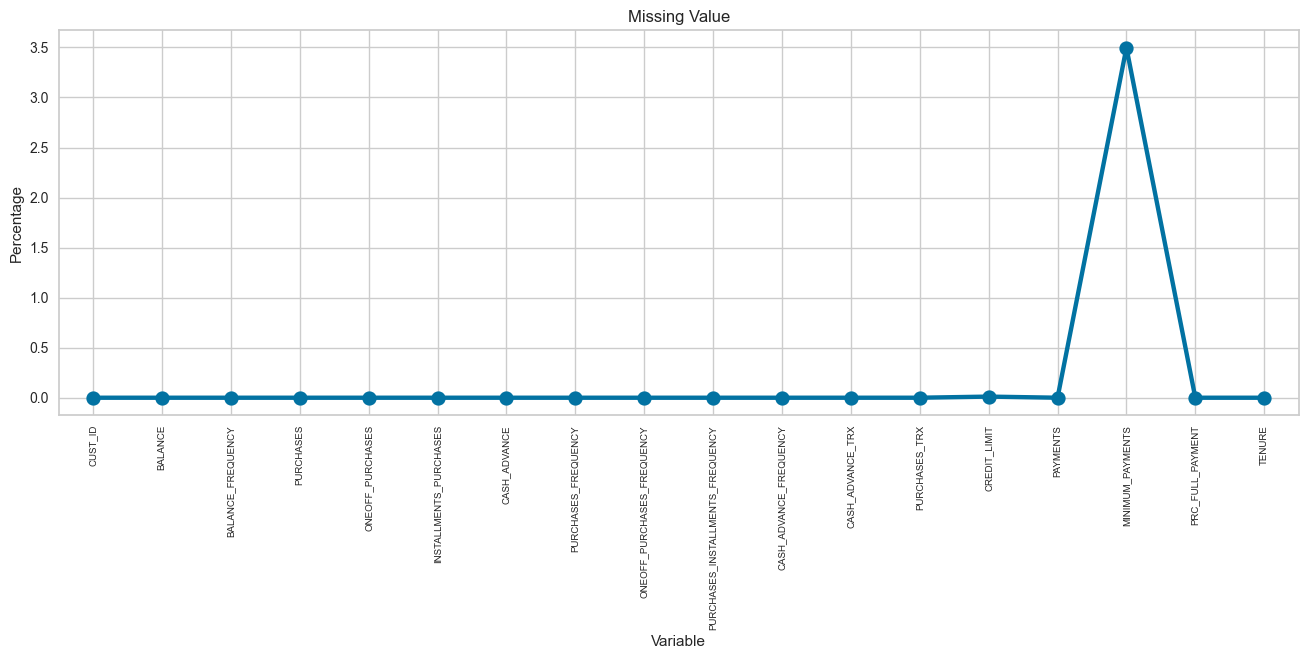

In [3]:
def missing_data():
    # Creation of new df to calculate percentage of missing data
    missing = pd.DataFrame((df.isnull().sum()) * 100 / df.shape[0]).reset_index()
    missing.columns = ['Column', 'Percentage']

    # Plotting using seaborn
    fig, ax = plt.subplots(figsize=(16, 5))
    sns.pointplot(x='Column', y='Percentage', data=missing)
    ax.set_title('Missing Value')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Variable')
    ax.set_xticklabels(ax.get_xticklabels(), rotation =90, fontsize = 7)
    ax.grid(True)
    plt.show()


missing_data()

In [4]:
# Calculate Nan percent in each column
nan_percent_pa = (df.isna().sum() / len(df)) * 100


# Create a DataFrame from the series
nan_percent_pa_df = nan_percent_pa.reset_index()
nan_percent_pa_df.columns = ['Column', 'NaN_Percent']


# Sort the DataFrame by the percentage of NaNs in ascending order
nan_percent_df = nan_percent_pa_df.sort_values(by='NaN_Percent', ascending=False)


# Print the top variable with missing data in the variable. Because there is 14 variable with missing data therefore only the top 14 is display.
print(clr.start + 'Tabular format of missing value' + clr.end)
print(clr.color + '*'*23)
nan_percent_df.head(5)

Tabular format of missing value
***********************


,Column,NaN_Percent
15,MINIMUM_PAYMENTS,3.497207
13,CREDIT_LIMIT,0.011173
1,BALANCE,0.000000
0,CUST_ID,0.000000
2,BALANCE_FREQUENCY,0.000000


### Handle Missing Value

Based on the line chart below, it show the remaining missing data within the variable. There is currently 11 column with missing data less than 5%.

In [5]:
# Empty list for storing variable with missing data
variables = []


# Create a for loop identifying variable with missing data
for col in df.columns:
    if df[col].isnull().any():
        variables.append(col)


# Empty list for storing categorical data
numeric = []
object = []


# For loop to identify the data types and appending it
for variable in variables:
    if df[variable].dtypes == 'float64' or df[variable].dtypes == 'int':
        numeric.append(variable)
    else:
        object.append(variable)


# Print out the variable based on category
print(clr.start + 'Numeric Data Structure' + clr.end)
for i,item in enumerate(numeric):
    print(i,item)
print('\n')

print(clr.start + 'Object Data Structure' + clr.end)
for i,item in enumerate(object):
    print(i,item)

Numeric Data Structure
0 CREDIT_LIMIT
1 MINIMUM_PAYMENTS


Object Data Structure


Calculating the mean for the variable with missing data to replace the missing values.

In [6]:
mean = []
print(clr.start + 'Mean Value' + clr.end)
for j in numeric:
    m = df[j].mean().round(2)
    mean.append(m)
    print(j,m)

Mean Value
CREDIT_LIMIT 4494.45
MINIMUM_PAYMENTS 864.21


Replace the numeric missing value

In [7]:
numeric_tuple = zip(numeric,mean)

# .infer_objects(copy = False)
# It is a function which it will create another copy of the original data frame
# The goal is to infer the data type again after data manipulation

for col,value in numeric_tuple:
    df[col] = df[col].fillna(value).infer_objects(copy=False)

Double Checking Missing Value

In [8]:
# Calculate Nan percent in each column
nan_percent_pa = (df.isna().sum() / len(df)) * 100


# Create a DataFrame from the series
nan_percent_pa_df = nan_percent_pa.reset_index()
nan_percent_pa_df.columns = ['Column', 'NaN_Percent']


# Sort the DataFrame by the percentage of NaNs in ascending order
nan_percent_df = nan_percent_pa_df.sort_values(by='NaN_Percent', ascending=False)


# Print the top variable with missing data in the variable. Because there is 14 variable with missing data therefore only the top 14 is display.
nan_percent_df.head(5)

,Column,NaN_Percent
0,CUST_ID,0.0
1,BALANCE,0.0
2,BALANCE_FREQUENCY,0.0
3,PURCHASES,0.0
4,ONEOFF_PURCHASES,0.0


## EDA

In [9]:
#  Identify data types
print(clr.start + 'Unique Data Type in dataset' + clr.end)
[print(i) for i in df.dtypes.unique()]

Unique Data Type in dataset
object
float64
int64


[None, None, None]

In [10]:
#  Seperating the variable into data types  
numeric_variable = [variable for variable in df if df[variable].dtypes in ['float64','int64']]
object_variable = variable = [variable for variable in df if df[variable].dtypes not in ['float64','int64']]

#  Numeric 
print(clr.start + 'Numeric Variable' + clr.end)
numeric_variable

Numeric Variable


['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [11]:
# Object
print(clr.start + 'Object Variable' + clr.end)
object_variable

# Removal of variable
df_copy = df.copy()
df_copy.drop('CUST_ID', axis = 1, inplace=True)

Object Variable


### Univariate Analysis

In [12]:
print(clr.start + 'Descriptive Statistics' + clr.end)
df_copy.describe()

Descriptive Statistics


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206663,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.210000,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


#### Distribution

**Insight**

**One Off Purchase Frequency**
 * It can be seen that the one off purchase is skew negativetely therefore reflecting that majority of the user are repeated.

 **Purchase Frequency**
  * It shows an opposite of a normal distribution, instead the peak are located on the extreme end of the distribution. This reflect that the user are heavily within the extreme point when looking in term of purchasing frequency. It can be seen that either there are two type of user which are very conservative and very aggresive buyer and minimal moderate purchase frequency.



C:\Users\Sam\AppData\Local\Temp\ipykernel_2680\327606961.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, fontsize=10)
C:\Users\Sam\AppData\Local\Temp\ipykernel_2680\327606961.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, fontsize=10)
C:\Users\Sam\AppData\Local\Temp\ipykernel_2680\327606961.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, fontsize=10)
C:\Users\Sam\AppData\Local\Temp\ipykernel_2680\327606961.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

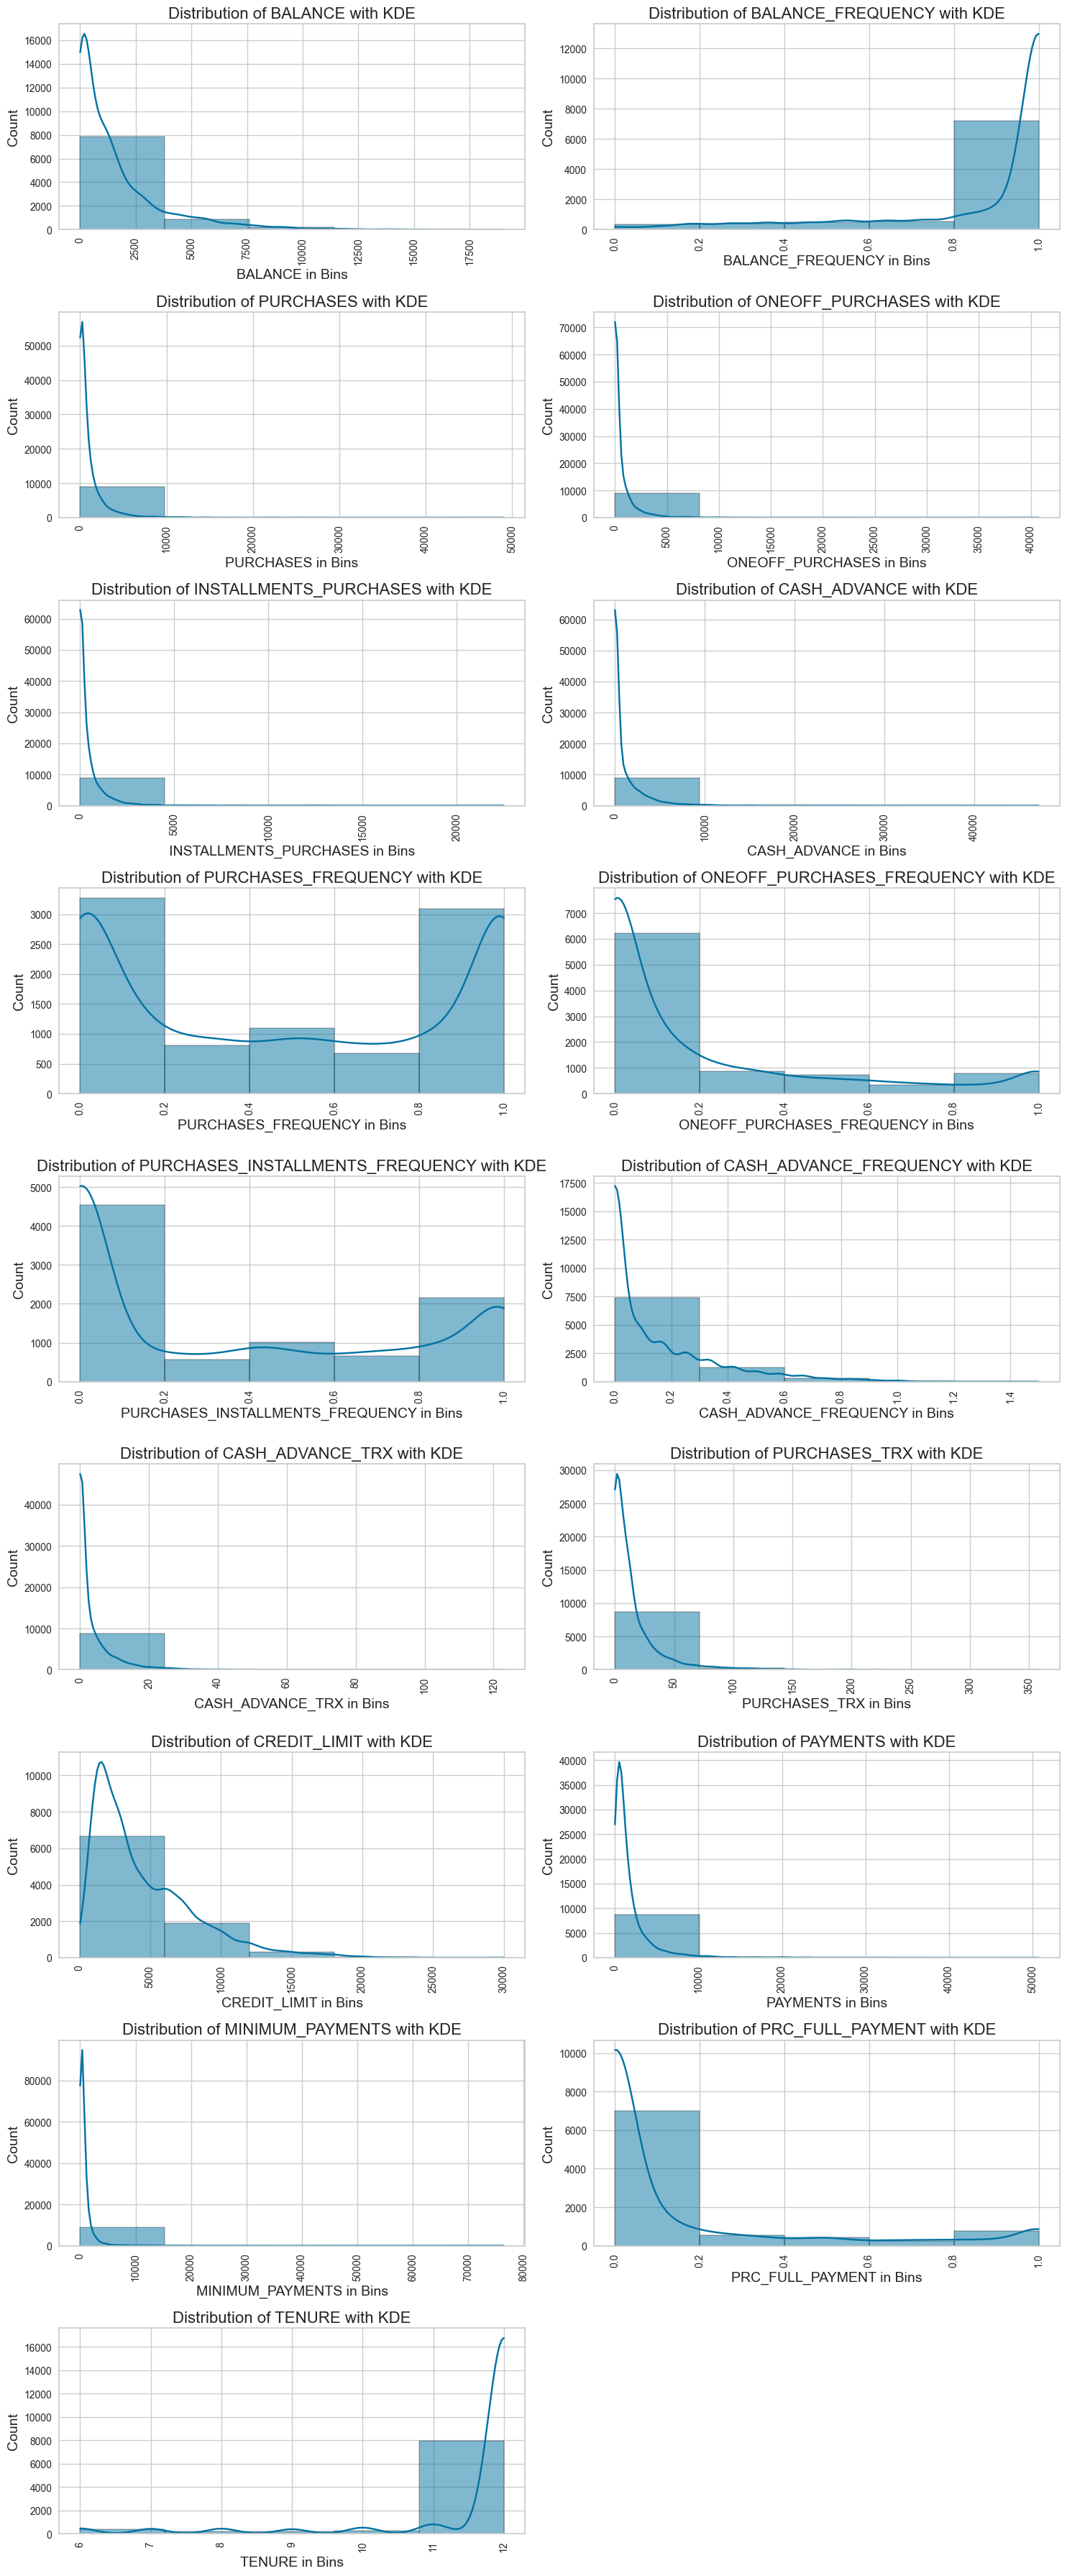

In [13]:
# Determine the number of rows and columns for the subplots
num_cols = 2  # Number of columns
num_rows = (len(numeric_variable) + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, col in enumerate(numeric_variable):
    sns.histplot(df[col], bins=5, kde=True, edgecolor='k', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col} with KDE', size=16)
    axes[idx].set_xlabel(f'{col} in Bins', size=14)
    axes[idx].set_ylabel('Count', size=14)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, fontsize=10)
    axes[idx].grid(True)

# Remove any empty subplots
for ax in axes[len(numeric_variable):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Bivariate Analysis

The heatmap below show the correlation between the variable in the dataset.

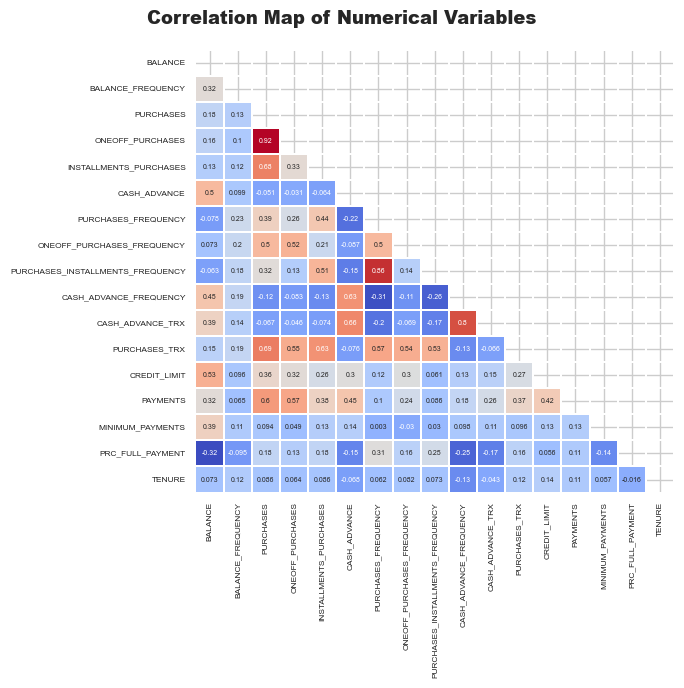

In [14]:
def heatmap():
    '''
    Mask would mean to hide.

    one_like function generate an exact matrix with the value of 1

    np.triu function mean upper triangle

    ytick and xtick are used to manipulate the x & y value.
    '''
    mask = np.triu(np.ones_like(df_copy.corr(), dtype=bool)) 

    fig, ax = plt.subplots(figsize=(7, 7))
    # Plot the correlation 
    sns.heatmap(df_copy.corr(), mask=mask, annot=True, cmap='coolwarm', linewidths=0.1, cbar=False, annot_kws={"size":5})

    yticks, ylabels = plt.yticks()
    xticks, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=6)
    ax.set_yticklabels(ylabels, size=6)
    plt.suptitle('Correlation Map of Numerical Variables', fontweight='heavy', fontsize=13)
    plt.tight_layout()
    plt.show()

heatmap()

### Multivariate Analysis

PCA 1 have a variance of 0.27% and PCA 2 have a variance of 0.2%.

The total variance would be 0.48%


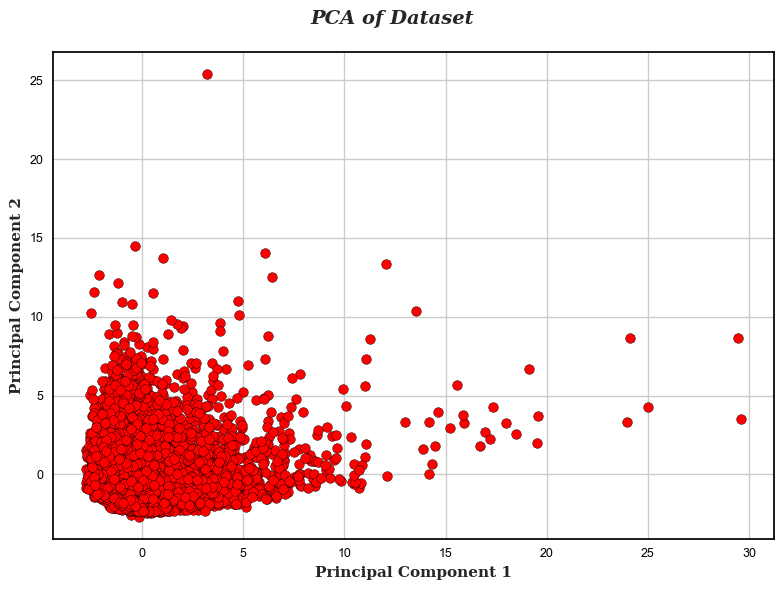

In [15]:
def pca_prep(df_copy): 
    X = pd.DataFrame(StandardScaler().fit_transform(df_copy))
    X = np.asarray(X)
    pca = PCA(n_components=2, random_state=20)
    X = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_
    print(clr.start + f'PCA 1 have a variance of {explained_variance[0].round(2)}% and PCA 2 have a variance of {explained_variance[1].round(2)}%.' + clr.end)
    print(clr.start + f'\nThe total variance would be {(explained_variance[0]+explained_variance[1]).round(2)}%' + clr.end) 
    return X


def plot_pca(X):
    # figure setting 
    title=dict(fontsize=14, fontweight='bold', style='italic', fontfamily='serif')
    text_style=dict(fontweight='bold', fontfamily='serif', fontsize=11)
    # Plot PCA
    principal_df = pd.DataFrame(data=X, columns=['PC1', 'PC2'])
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_df['PC1'], principal_df['PC2'], c='#FF0000', edgecolor='#000000')  # Red points with black edges
    plt.xlabel('Principal Component 1', **text_style)
    plt.ylabel('Principal Component 2', **text_style)
    plt.suptitle('PCA of Dataset', **title)
    plt.gca().spines['top'].set_color('#000000')
    plt.gca().spines['right'].set_color('#000000')
    plt.gca().spines['left'].set_color('#000000')
    plt.gca().spines['bottom'].set_color('#000000')
    plt.gca().tick_params(axis='both', colors='#000000')
    plt.tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

X = pca_prep(df_copy)
plot_pca(X)

## Clustering

### K Mean

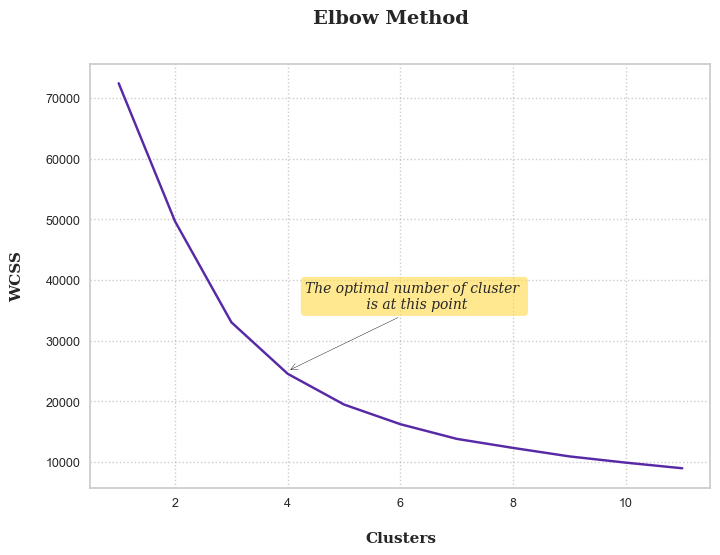

In [16]:
def cluster_number(min_cluster, max_cluster, cluster_algo):
    text_style=dict(fontweight='bold', fontfamily='serif')
    bbox=dict(boxstyle='round', pad=0.3, color='#FFDA47', alpha=0.6)
    txt1=dict(textcoords='offset points', va='center', ha='center', fontfamily='serif', style='italic')
    kw=dict(arrowstyle='<-', color='black')
    wcss = []

    for i in range(min_cluster,max_cluster+1):
        kmeans = KMeans(n_clusters = i, init = cluster_algo, max_iter = 100, n_init = 10, random_state = 5)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(min_cluster,max_cluster+1), wcss,color='#5829A7')
    plt.suptitle('Elbow Method\n', fontsize = 14, **text_style)
    plt.xlabel('\nClusters', fontsize=11, **text_style)
    plt.ylabel('WCSS\n', fontsize=11, **text_style)
    plt.grid(axis = 'both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.annotate('The optimal number of cluster \n is at this point', xy=(6,35000), xytext=(10,10),fontsize=10, bbox=bbox, **txt1)
    plt.annotate('', xy=(6,34000), xytext=(4, 25000), arrowprops=kw)
    plt.tick_params(labelsize=9)
    plt.tight_layout
    plt.show()


cluster_number(1,11,'k-means++')

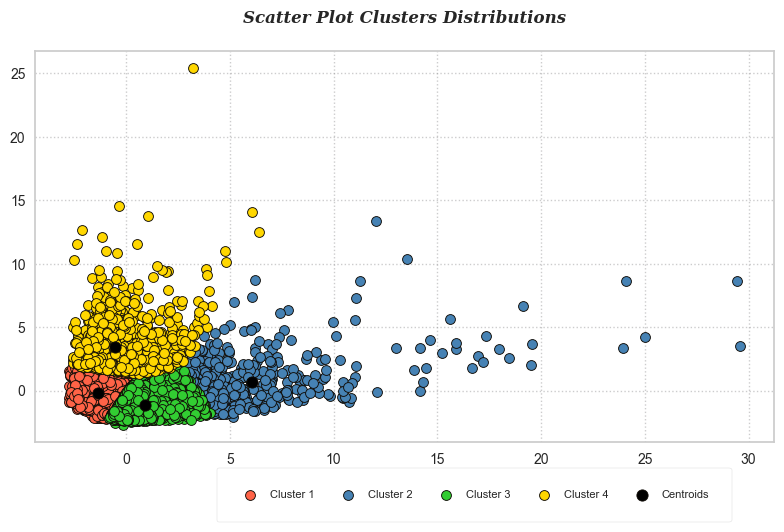

The evaluation of the model based on Inertia would be 24525.6.
The evaluation of the model based on Silhouette would be 0.41.
The evaluation of the model based on Davies-Bouldin Score would be 0.8.
The evaluation of the model based on Calinski-Harabasz Score would be 5822.44.


In [17]:
# --- Implementing K-Means ---
def kmean_init(no_cluster, random_state, max_iter, X):
    kmeans = KMeans(n_clusters=no_cluster, random_state=random_state, max_iter=max_iter)
    y_kmeans = kmeans.fit_predict(X)
    return kmeans, y_kmeans 


# --- Figures Settings ---
def figure_setting():
    cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Centroids']
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style=dict(fontweight='bold', fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07')
    legend_style=dict(borderpad=2, frameon=True, fontsize=8)
    fig, ax = plt.subplots()
    return fig, ax, cluster_colors, labels, title, scatter_style, legend_style


# --- Clusters Distribution ---
def kmean(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, y_kmeans):
    y_kmeans_labels = list(set(y_kmeans.tolist()))
    for i in y_kmeans_labels:
        ax.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s=50, c=cluster_colors[i], **scatter_style)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=65, c='#000000', label='Centroids', **scatter_style)
    ax.set_title('Scatter Plot Clusters Distributions\n', **title)
    ax.legend(labels, bbox_to_anchor=(0.95, -0.05), ncol=5, **legend_style)
    ax.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.tight_layout()
    plt.show()


# Calculate metrics
def metric(cluster, y_ClusterAlgo):
    inertia = cluster.inertia_
    silhouette_avg = silhouette_score(X, y_ClusterAlgo)
    davies_bouldin = davies_bouldin_score(X, y_ClusterAlgo)
    calinski_harabasz = calinski_harabasz_score(X, y_ClusterAlgo)

    metric_dict = {
        'Inertia':inertia,
        'Silhouette': silhouette_avg,
        'Davies-Bouldin Score': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
        }
    
    for key, value in metric_dict.items():
        print(f'The evaluation of the model based on {key} would be {round(value,2)}.')


kmeans, y_kmeans = kmean_init(4,23,1000,X)
fig, ax, cluster_colors, labels, title, scatter_style, legend_style = figure_setting()
kmean(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, y_kmeans)
metric(kmeans,y_kmeans)

### DBSCAN

<Figure size 1400x500 with 0 Axes>

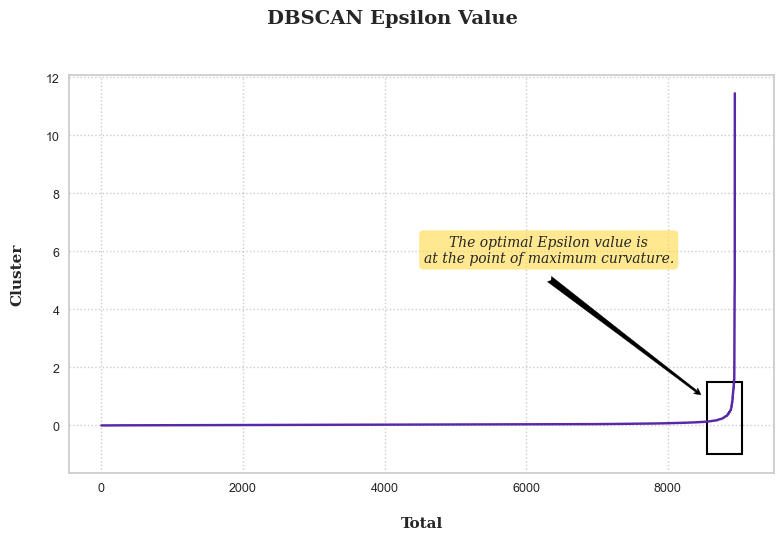

In [18]:
def Euclidean_distance(n_neighbors):
    ''' 
    Euclidean distance is used to find the nearest neighbour for the data points. 
    '''
    neighbors=NearestNeighbors(n_neighbors=n_neighbors)
    nbrs=neighbors.fit(X)
    distances, indices=nbrs.kneighbors(X)
    distances=np.sort(distances, axis = 0)
    return distances, indices


# Epsilon Values
def epsilon(distance):
    '''
     This would be the setting for design
    '''
    bbox=dict(boxstyle='round', pad=0.3, color='#FFDA47', alpha=0.6)
    txt1=dict(textcoords='offset points', va='center', ha='center', fontfamily='serif', style='italic')
    kw=dict(arrowstyle='Fancy', color='black')
    text_style=dict(fontweight='bold', fontfamily='serif')
    fig=plt.figure(figsize=(14, 5))

    
    ''' 
    This would be to plot the epsilon plot.
    '''
    distances_1=distances[:, 1]
    fig, ax1 = plt.subplots()
    plt.plot(distances_1, color='#5829A7')
    plt.xlabel('\nTotal', fontsize=11, **text_style)
    plt.ylabel('Cluster\n', fontsize=11, **text_style)
    ax1.add_patch(Rectangle((8550, -1), 500, 2.5, edgecolor='#000000', fill=False, lw=1.5))
    plt.annotate('The optimal Epsilon value is\nat the point of maximum curvature.', xy=(6300, 6), xytext=(1, 1), fontsize=10, bbox=bbox, **txt1)
    plt.annotate('', xy=(8500, 1), xytext=(6300, 5.1), arrowprops=kw)
    plt.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.tick_params(labelsize=9)
    plt.suptitle('DBSCAN Epsilon Value\n', fontsize=14, **text_style)
    plt.tight_layout()
    plt.show();


distances,indices = Euclidean_distance(5)
epsilon(distances);

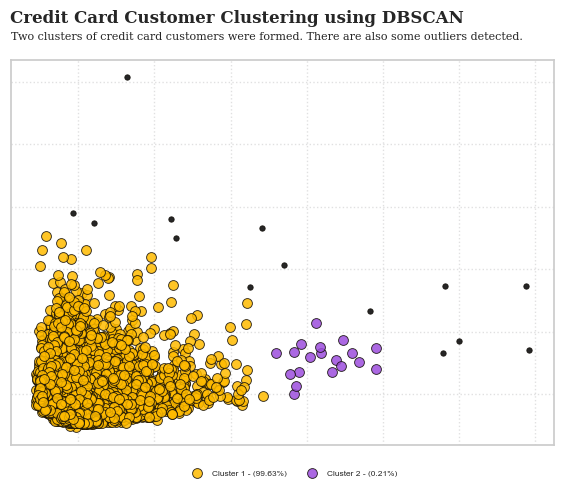

The evaluation of the model based on Silhouette would be 0.8.
The evaluation of the model based on Davies-Bouldin Score would be 1.29.
The evaluation of the model based on Calinski-Harabasz Score would be 685.28.


In [19]:
# --- Implementing DBSCAN ---
dbscan = DBSCAN(eps=2, min_samples=4)
y_dbscan = dbscan.fit_predict(X)
    
# --- Define DBSCAN Result Distribution ---
def dbscan_visualizer(dbscan, y_dbscan):
    
    # --- Figures Settings ---
    cluster_colors=['#FFBB00', '#9D4EDD', 'black']
    labels = ['Cluster 1', 'Cluster 2', 'Outliers']
    suptitle=dict(fontsize=12, fontweight='heavy', fontfamily='serif')
    title=dict(fontsize=8, fontfamily='serif')
    scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)
    legend_style=dict(borderpad=2, frameon=False, fontsize=6)
    
    # --- Percentage labels ---
    unique, counts = np.unique(y_dbscan, return_counts=True)
    dbscan_count = dict(zip(unique, counts))
    total = sum(dbscan_count.values())
    dbscan_label = {key: round(value/total*100, 2) for key, value in dbscan_count.items() if key != -1}

    # --- Clusters Distribution ---
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for i in np.arange(0, 2, 1):
        plt.scatter(X[y_dbscan==i, 0], X[y_dbscan == i, 1], s=50, c=cluster_colors[i], label=labels[i], **scatter_style)
    plt.scatter(X[y_dbscan==-1, 0], X[y_dbscan == -1, 1], s=15, c=cluster_colors[2], label=labels[2], **scatter_style)
    plt.legend([f"Cluster {i+1} - ({k}%)" for i, k in dbscan_label.items()], bbox_to_anchor=(0.75, -0.01), ncol=3, **legend_style)
    plt.grid(axis='both', alpha=0.3, color='#9B9A9C', linestyle='dotted')
    plt.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)
    plt.title('Two clusters of credit card customers were formed. There are also some outliers detected.\n', loc='left', **title)
    plt.suptitle('Credit Card Customer Clustering using DBSCAN', x=0.123, y=0.98, ha='left', **suptitle)
    plt.show();


# Calculate metrics
def metric(cluster, y_ClusterAlgo):
    silhouette_avg = silhouette_score(X, y_ClusterAlgo)
    davies_bouldin = davies_bouldin_score(X, y_ClusterAlgo)
    calinski_harabasz = calinski_harabasz_score(X, y_ClusterAlgo)

    metric_dict = {
        'Silhouette': silhouette_avg,
        'Davies-Bouldin Score': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
        }
    
    for key, value in metric_dict.items():
        print(f'The evaluation of the model based on {key} would be {round(value,2)}.')


# --- Calling DBSCAN Functions ---
dbscan_visualizer(dbscan, y_dbscan);
metric(dbscan, y_dbscan)

### Hierarchical Clustering (Agglomerative)

<Figure size 1400x500 with 0 Axes>

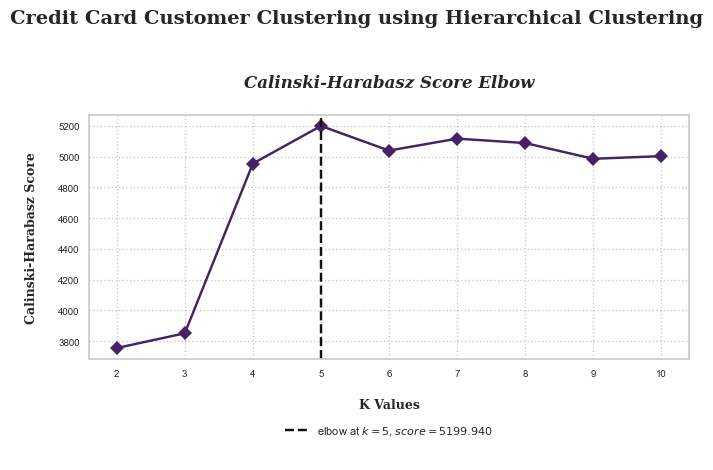

In [20]:
def agg_dendrogram():
    
    # --- Figure Settings ---
    color_palette=['#472165', '#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
    set_palette(color_palette)
    text_style=dict(fontweight='bold', fontfamily='serif')
    title=dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    fig=plt.figure(figsize=(14, 5))
    
    # --- Elbow Score (Calinski-Harabasz Index) ---
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    elbow_score_ch = KElbowVisualizer(AgglomerativeClustering(), metric='calinski_harabasz', timings=False, ax=ax)
    elbow_score_ch.fit(X)
    elbow_score_ch.finalize()
    elbow_score_ch.ax.set_title('Calinski-Harabasz Score Elbow\n', **title)
    elbow_score_ch.ax.tick_params(labelsize=7)
    for text in elbow_score_ch.ax.legend_.texts:
        text.set_fontsize(9)
    elbow_score_ch.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), borderpad=2, frameon=False, fontsize=8)
    elbow_score_ch.ax.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    elbow_score_ch.ax.set_xlabel('\nK Values', fontsize=9, **text_style)
    elbow_score_ch.ax.set_ylabel('Calinski-Harabasz Score\n', fontsize=9, **text_style)
    
    plt.suptitle('Credit Card Customer Clustering using Hierarchical Clustering\n', fontsize=14, **text_style)
    plt.tight_layout()
    plt.show();


agg_dendrogram();

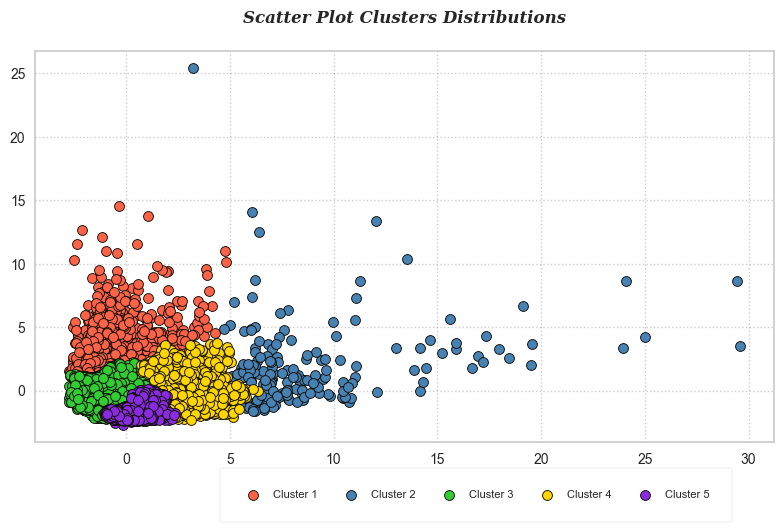

The evaluation of the model based on Silhouette would be 0.34.
The evaluation of the model based on Davies-Bouldin Score would be 0.88.
The evaluation of the model based on Calinski-Harabasz Score would be 5199.94.


In [21]:
def agglo_init(no_cluster, linkage, X):
    agglo = AgglomerativeClustering(n_clusters=no_cluster, linkage=linkage)
    y_agglo_cluster = agglo.fit_predict(X)
    return agglo, y_agglo_cluster 


def figure_setting():
    cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']
    labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
    title = dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style = dict(fontweight='bold', fontfamily='serif')
    scatter_style = dict(linewidth=0.65, edgecolor='#100C07')
    legend_style = dict(borderpad=2, frameon=True, fontsize=8)
    fig, ax = plt.subplots()
    return fig, ax, cluster_colors, labels, title, scatter_style, legend_style


def plot_agglo_clusters(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, X, y_agglo_cluster):
    for i, color in zip(np.unique(y_agglo_cluster), cluster_colors):
        ax.scatter(X[y_agglo_cluster == i, 0], X[y_agglo_cluster == i, 1], s=50, c=color, **scatter_style)
    ax.set_title('Scatter Plot Clusters Distributions\n', **title)
    ax.legend(labels, bbox_to_anchor=(0.95, -0.05), ncol=5, **legend_style)
    ax.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.tight_layout()
    plt.show()


def metric(y_ClusterAlgo, X):
    silhouette_avg = silhouette_score(X, y_ClusterAlgo)
    davies_bouldin = davies_bouldin_score(X, y_ClusterAlgo)
    calinski_harabasz = calinski_harabasz_score(X, y_ClusterAlgo)

    metric_dict = {
        'Silhouette': silhouette_avg,
        'Davies-Bouldin Score': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
        }
    
    for key, value in metric_dict.items():
        print(f'The evaluation of the model based on {key} would be {round(value,2)}.')


agglo, y_agglo_cluster = agglo_init(5, 'ward', X)
fig, ax, cluster_colors, labels, title, scatter_style, legend_style = figure_setting()
plot_agglo_clusters(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, X, y_agglo_cluster)
metric(y_agglo_cluster, X)

### OPTICS

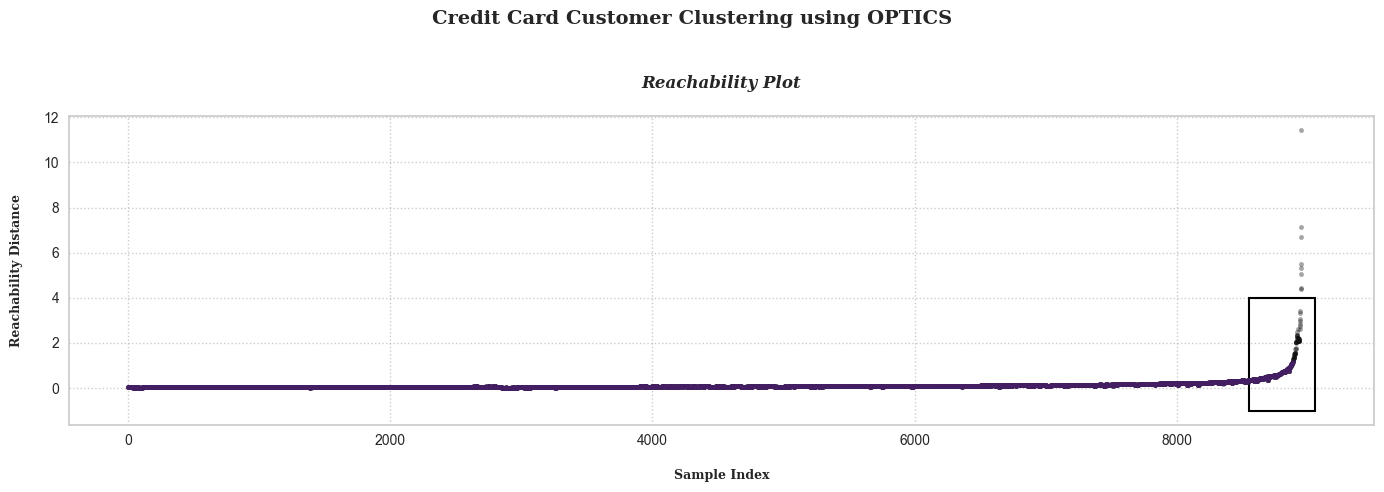

In [22]:
def optics_reachability_plot(X):
    # --- Figure Settings ---
    color_palette = ['#472165', '#FFBB00', '#3C096C', '#9D4EDD', '#FFE270']
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_palette)
    text_style = dict(fontweight='bold', fontfamily='serif')
    title = dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    kw=dict(arrowstyle='Fancy', color='black')
    
    # --- Reachability Plot ---
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))
    optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.1)
    optics.fit(X)
    space = np.arange(len(X))
    reachability = optics.reachability_[optics.ordering_]
    labels = optics.labels_[optics.ordering_]
    ax.plot(space, reachability, 'k.', alpha=0.3)
    for klass, color in zip(range(0, 5), color_palette):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        ax.plot(Xk, Rk, color, alpha=0.3, marker='.')
    ax.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.1)
    ax.set_ylabel('Reachability Distance\n', fontsize=9, **text_style)
    ax.set_xlabel('\nSample Index', fontsize=9, **text_style)
    ax.set_title('Reachability Plot\n', **title)
    ax.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.suptitle('Credit Card Customer Clustering using OPTICS\n', fontsize=14, **text_style)
    ax.add_patch(Rectangle((8550,-1),500,5, edgecolor = '#000000', fill=False,lw=1.5))
    plt.tight_layout()
    plt.show()

optics_reachability_plot(X)

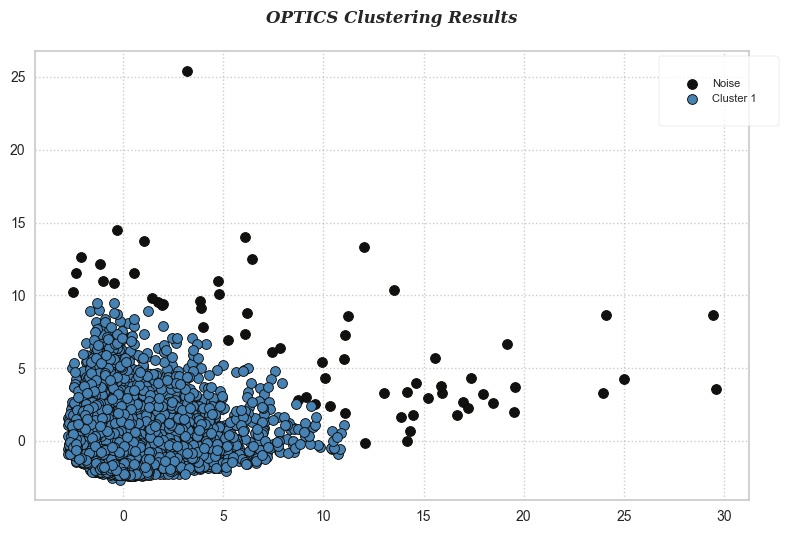

The evaluation of the model based on Silhouette would be 0.78.
The evaluation of the model based on Davies-Bouldin Score would be 0.81.
The evaluation of the model based on Calinski-Harabasz Score would be 1425.8.


In [23]:
def optics_init(X, min_samples=10, xi=0.05, min_cluster_size=0.1):
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    optics.fit(X)
    y_optics_cluster = optics.labels_
    return optics, y_optics_cluster

def figure_setting():
    cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']
    labels = ['Cluster 1', 'Cluster 2', 'Noise']  # Adjust labels for fewer clusters
    title = dict(fontsize=12, fontweight='bold', style='italic', fontfamily='serif')
    text_style = dict(fontweight='bold', fontfamily='serif')
    scatter_style = dict(linewidth=0.65, edgecolor='#100C07')
    legend_style = dict(borderpad=2, frameon=True, fontsize=8)
    fig, ax = plt.subplots()
    return fig, ax, cluster_colors, labels, title, scatter_style, legend_style

def plot_optics_clusters(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, X, y_optics_cluster):
    unique_labels = np.unique(y_optics_cluster)
    colors = cluster_colors[:len(unique_labels)] if len(unique_labels) <= len(cluster_colors) else plt.cm.get_cmap('tab20', len(unique_labels))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'k'  # Noise points
        mask = y_optics_cluster == label
        ax.scatter(X[mask, 0], X[mask, 1], s=50, c=color, label=labels[label], **scatter_style)
    
    ax.set_title('OPTICS Clustering Results\n', **title)
    ax.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1, **legend_style)
    ax.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
    plt.tight_layout()
    plt.show()

def metric(y_ClusterAlgo, X):
    silhouette_avg = silhouette_score(X, y_ClusterAlgo)
    davies_bouldin = davies_bouldin_score(X, y_ClusterAlgo)
    calinski_harabasz = calinski_harabasz_score(X, y_ClusterAlgo)

    metric_dict = {
        'Silhouette': silhouette_avg,
        'Davies-Bouldin Score': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
    }


    for key, value in metric_dict.items():
        print(f'The evaluation of the model based on {key} would be {round(value,2)}.')


optics, y_optics_cluster = optics_init(X)
fig, ax, cluster_colors, labels, title, scatter_style, legend_style = figure_setting()
plot_optics_clusters(fig, ax, cluster_colors, labels, title, scatter_style, legend_style, X, y_optics_cluster)
metric(y_optics_cluster, X)


## Result

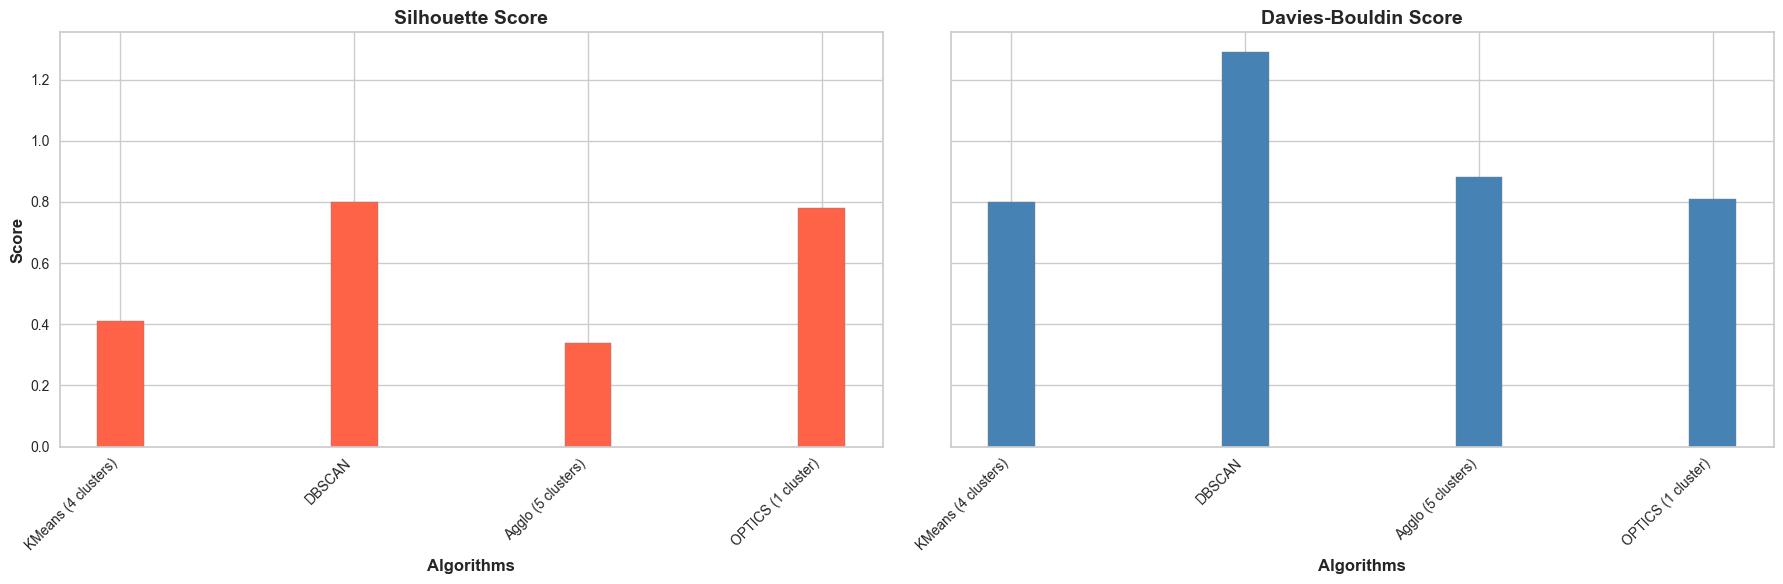

In [35]:
def metric_plot():
    algorithms = ['KMeans (4 clusters)', 'DBSCAN', 'Agglo (5 clusters)', 'OPTICS (1 cluster)']
    silhouette_scores = [0.41, 0.8, 0.34, 0.78]
    davies_bouldin_scores = [0.8, 1.29, 0.88, 0.81]

    # Bar width
    bar_width = 0.2

    # X locations for the groups
    r1 = np.arange(len(algorithms))

    # Create the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # Plot Silhouette Scores
    axs[0].bar(r1, silhouette_scores, color='#FF6347', width=bar_width, edgecolor='grey')
    axs[0].set_title('Silhouette Score', fontsize=14, fontweight='bold')
    axs[0].set_xlabel('Algorithms', fontsize=12, fontweight='bold')
    axs[0].set_ylabel('Score', fontsize=12, fontweight='bold')
    axs[0].set_xticks(r1)
    axs[0].set_xticklabels(algorithms, rotation=45, ha='right')

    # Plot Davies-Bouldin Scores
    axs[1].bar(r1, davies_bouldin_scores, color='#4682B4', width=bar_width, edgecolor='grey')
    axs[1].set_title('Davies-Bouldin Score', fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Algorithms', fontsize=12, fontweight='bold')
    axs[1].set_xticks(r1)
    axs[1].set_xticklabels(algorithms, rotation=45, ha='right')

    # Adjust layout
    plt.tight_layout()
    plt.show()


metric_plot()

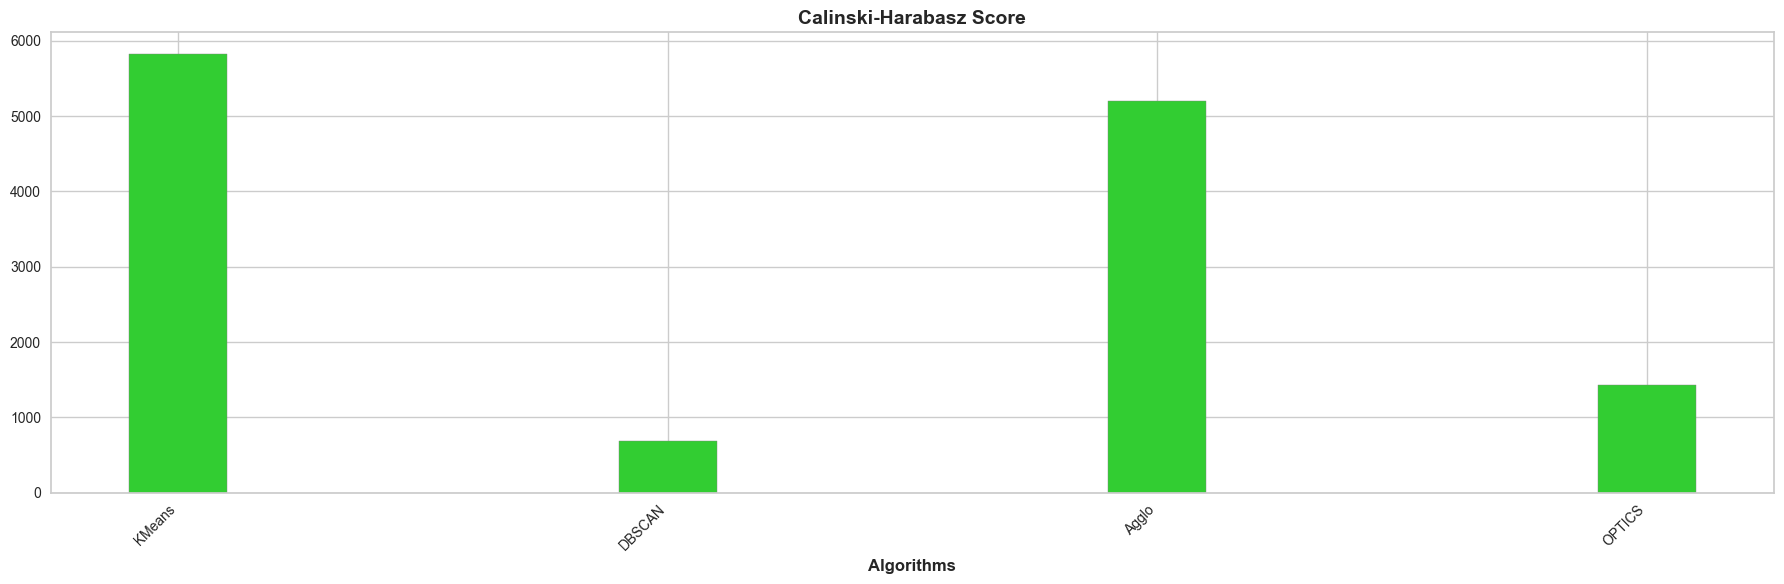

In [36]:
def metric_plot():
    algorithms = ['KMeans', 'DBSCAN', 'Agglo', 'OPTICS']
    calinski_harabasz_scores = [5822.44, 685.28, 5199.94, 1425.8]

    # Bar width
    bar_width = 0.2

    # X locations for the groups
    r1 = np.arange(len(algorithms))

    # Create the figure and subplots
    fig, ax = plt.subplots(figsize=(18, 6), sharey=True)

    # Plot Calinski-Harabasz Scores
    ax.bar(r1, calinski_harabasz_scores, color='#32CD32', width=bar_width, edgecolor='grey')
    ax.set_title('Calinski-Harabasz Score', fontsize=14, fontweight='bold')
    ax.set_xlabel('Algorithms', fontsize=12, fontweight='bold')
    ax.set_xticks(r1)
    ax.set_xticklabels(algorithms, rotation=45, ha='right')

    # Adjust layout
    plt.tight_layout()
    plt.show()


metric_plot()

| Algorithm                        | Clusters | Silhouette Score | Davies-Bouldin Score | Calinski-Harabasz Score |
|----------------------------------|----------|------------------|-----------------------|--------------------------|
| KMeans                           | 4        | 0.41             | 0.8                   | 5822.44                  |
| DBSCAN                           | 2        | 0.8              | 1.29                  | 685.28                   |
| Agglomerative Clustering (Agglo) | 5        | 0.34             | 0.88                  | 5199.94                  |
| OPTICS                           | 1        | 0.78             | 0.81                  | 1425.8                   |


The clustering evaluation metrics shows that KMeans performs the best overall, showcasing strong clustering quality with a high Silhouette Score (0.41), a low Davies-Bouldin Score (0.8), and a high Calinski-Harabasz Score (5822.44). This suggests that KMeans produces well-defined, compact clusters with good separation. DBSCAN also performs well with a high Silhouette Score (0.8) but has a higher Davies-Bouldin Score (1.29) and a lower Calinski-Harabasz Score (685.28), indicating less distinct and more variable clusters. Agglomerative Clustering (Agglo) shows moderate performance with a Silhouette Score of 0.34 and a Davies-Bouldin Score of 0.88, reflecting less clear cluster separation. OPTICS, with a Silhouette Score of 0.78, has good clustering but lower Calinski-Harabasz (1425.8) and Davies-Bouldin Scores (0.81), suggesting moderate cluster compactness and separation. Overall, KMeans is the most effective for producing well-defined and compact clusters in this scenario.